In [ ]:
import numpy as np
from math import sqrt
import missingno as msno
from tqdm import tqdm
import os

import warnings # 불필요한 경고문 삭제
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime, to_timedelta, date_range

#tensorflow 2.0
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Adagrad, RMSprop, Nadam
from keras.layers.advanced_activations import LeakyReLU, PReLU
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
# 1-24시간 시간 단위 0-23시간 변환
def time_00(data, column):
    for num, i in tqdm(enumerate(data[column])):
        if str(i)[8:] == '24':
            temp = pd.to_datetime((str(i)[:8] + '00'), format = '%Y%m%d%H')
            i = temp + pd.to_timedelta('1d')
        data.loc[num, column] = pd.to_datetime(i, format='%Y%m%d%H')

In [ ]:
# 강수량 데이터 통합
df11 = pd.read_excel('장성남면_암반_수위.xlsx', sheet_name='2008-2019')
df12 = pd.read_excel('장성남면_암반_수위.xlsx', sheet_name='2020-2021')

def columns_eng(df):
    df.columns = ['관측소명', '관정형태', '일련번호', 'RESULT_ID', 'el', 'date', 'QLITY_ID']
    df.set_index('date', drop=True, inplace=True)
    df.index = pd.to_datetime(df11.index, format='%y/%m/%d %H:%M:%S')
    return df

df_1 = pd.concat((columns_eng(df11), columns_eng(df12)), axis=0)
df_1.sort_index()
df_1.index = pd.to_datetime(df_1.index.strftime('%Y%m%d%H'), format= '%Y%m%d%H')
df_1

,관측소명,관정형태,일련번호,RESULT_ID,el,QLITY_ID
date,,,,,,
2002-08-30 11:00:00,장성남면,암반,412547234,778,34.242,5
2002-08-30 17:00:00,장성남면,암반,412547235,778,34.242,5
2002-08-30 23:00:00,장성남면,암반,412547236,778,34.252,5
2002-08-31 05:00:00,장성남면,암반,412547237,778,34.262,5
2002-08-31 11:00:00,장성남면,암반,412547238,778,34.292,5
...,...,...,...,...,...,...
2021-09-30 19:00:00,장성남면,암반,1369108284,778,33.800,1
2021-09-30 20:00:00,장성남면,암반,1369108251,778,33.820,1
2021-09-30 21:00:00,장성남면,암반,1369119171,778,33.810,1


In [ ]:
# 강수량 데이터 통합
df21 = pd.read_excel('광주_강수량.xlsx', sheet_name='201002-201704')
df22 = pd.read_excel('광주_강수량.xlsx', sheet_name='201705-202109')
df21.columns = ['date', 'RFOBSCD', 'rain']
df22.columns = ['AMTPRCP_OBSRVT_CD', 'date', 'rain', 'rain_sum', 'CVACT_LVL', 'DAM_CD', 'CVACT_DT']
time_00(df21, 'date')
time_00(df22, 'date')
df21.set_index('date', drop=True, inplace=True)
df22.set_index('date', drop=True, inplace=True)
df_2 = pd.concat((df21, df22), axis=0)
df_2.sort_index()
df_2.index = pd.to_datetime(df_2.index.strftime('%Y%m%d%H'), format= '%Y%m%d%H')
df_2

61933it [03:43, 277.41it/s]
38674it [01:15, 511.82it/s]


,RFOBSCD,rain,AMTPRCP_OBSRVT_CD,rain_sum,CVACT_LVL,DAM_CD,CVACT_DT
date,,,,,,,
2010-02-03 00:00:00,8000156.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-02-03 01:00:00,8000156.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-02-03 02:00:00,8000156.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-02-03 03:00:00,8000156.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-02-03 04:00:00,8000156.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-09-30 20:00:00,NaN,0.0,8000156.0,NaN,100.0,7777777.0,NaN
2021-09-30 21:00:00,NaN,0.0,8000156.0,NaN,100.0,7777777.0,NaN
2021-09-30 22:00:00,NaN,0.0,8000156.0,NaN,100.0,7777777.0,NaN


In [ ]:
# 데이터 통합을 위해 인덱스 정렬
date_index=np.concatenate((df_1.index, df_2.index))
indexx = np.sort(date_index)
date_idx=pd.date_range(indexx[0], indexx[-1], freq='H')

In [ ]:
# 인덱스 정리 : 중복 제거, 재인덱싱
df_1 = df_1.reindex(date_idx)
df_2 = df_2.loc[~df_2.index.duplicated(keep='first')]
df_2 = df_2.reindex(date_idx)

# 데이터 통합
df = pd.concat((df_1[['el']], df_2[['rain']]), axis=1)
df.reset_index(drop=False, inplace=True)

<AxesSubplot:>

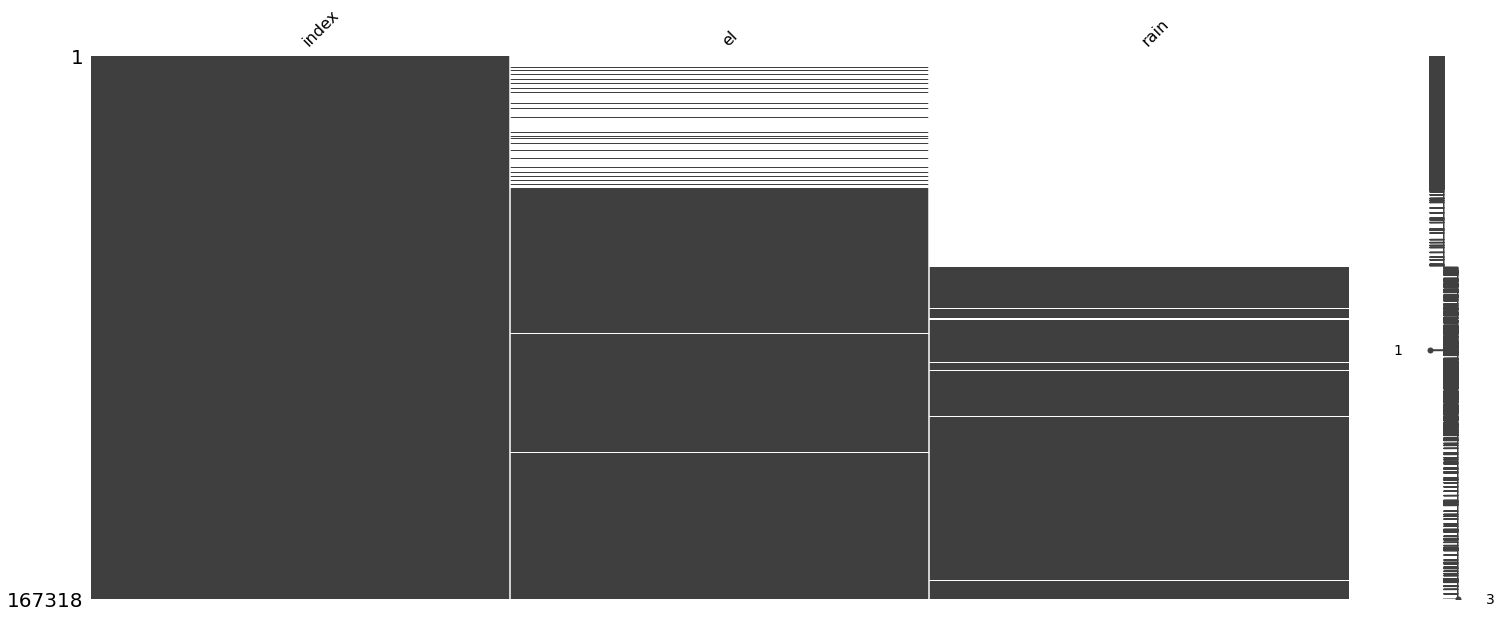

In [ ]:
# 결측치 확인
%matplotlib inline
msno.matrix(df)

In [ ]:
# 강수량이 최대 1998까지 존재
df.describe()

,el,rain
count,132692.000000,100223.000000
mean,33.486307,3.945652
std,1.623584,61.562705
min,0.000000,0.000000
25%,33.360000,0.000000
50%,33.600000,0.000000
75%,33.802000,0.000000
max,35.170000,1998.000000


In [ ]:
# 강수량이 0인 경우
new_df = df.iloc[df[df['rain'].isnull() != True].index[0]:, :]
new_df.set_index('index', drop=True, inplace=True)
new_df

,el,rain
index,,
2010-02-03 00:00:00,33.292,0.0
2010-02-03 01:00:00,33.292,0.0
2010-02-03 02:00:00,33.302,0.0
2010-02-03 03:00:00,33.302,0.0
2010-02-03 04:00:00,33.312,0.0
...,...,...
2021-09-30 20:00:00,33.820,0.0
2021-09-30 21:00:00,33.810,0.0
2021-09-30 22:00:00,33.820,0.0


In [ ]:
# 기상청 출처 실제 광주 강수량
ex_rain = pd.read_csv('rn_20211010094907.csv', encoding='euc-kr', date_parser='날짜')

In [ ]:
ex_rain

,날짜,지점,강수량(mm)
0,2010-01-01,156,0.0
1,2010-01-02,156,NaN
2,2010-01-03,156,NaN
3,2010-01-04,156,5.1
4,2010-01-05,156,3.6
...,...,...,...
4295,2021-10-05,156,NaN
4296,2021-10-06,156,NaN
4297,2021-10-07,156,NaN
4298,2021-10-08,156,0.0


In [ ]:
ex_rain.describe()

,지점,강수량(mm)
count,4300.0,1831.000000
mean,156.0,8.858984
std,0.0,18.880821
min,156.0,0.000000
25%,156.0,0.100000
50%,156.0,1.700000
75%,156.0,9.000000
max,156.0,259.500000


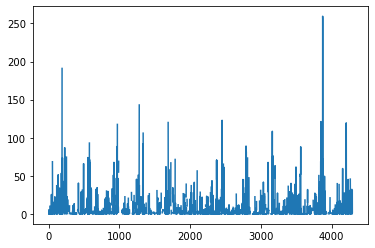

In [ ]:
plt.plot(ex_rain['강수량(mm)'])

In [ ]:
# 기상청 데이터의 최대 강수량을 참고하여 260 미만인 강수량만 추출
new_df.rain[new_df.rain.values < 260].describe()

count    99844.000000
mean         0.158498
std          1.263673
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         58.000000
Name: rain, dtype: float64

In [ ]:
for i in new_df.rain[new_df.rain.values >= 260].index:
    new_df.loc[i, 'rain'] = np.nan
new_df.describe()

,el,rain
count,102020.00000,99844.000000
mean,33.62739,0.158498
std,0.80431,1.263673
min,0.00000,0.000000
25%,33.42000,0.000000
50%,33.64100,0.000000
75%,33.82000,0.000000
max,35.17000,58.000000


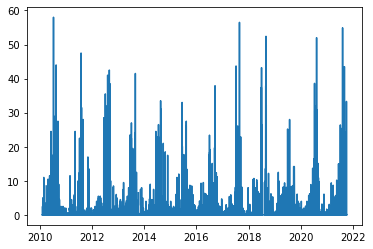

In [ ]:
# 광주 강수량을 참고한 수자원공사의 강수량
plt.plot(new_df.rain)

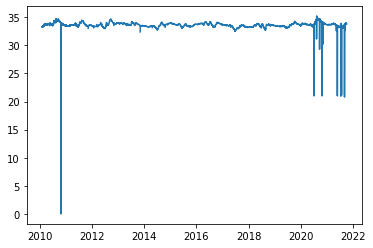

In [ ]:
# 지하수위 데이터 확인
plt.plot(new_df.el)

In [ ]:
new_df[new_df.el <= 1.0]

,el,rain
index,,
2010-10-20 12:00:00,0.08,0.0
2010-10-20 13:00:00,0.05,0.0
2010-10-20 14:00:00,0.02,0.0
2010-10-20 15:00:00,0.00,0.0
2010-10-20 16:00:00,0.00,0.0
2010-10-20 17:00:00,0.00,0.0
2010-10-20 18:00:00,0.01,0.0
2010-10-20 19:00:00,0.03,0.0
2010-10-20 20:00:00,0.04,0.0


# 기간별 지하수위 데이터 확인

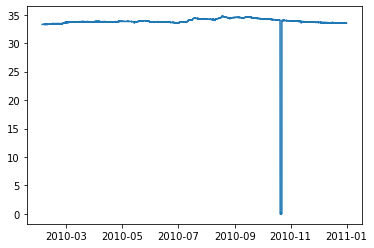

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2010-01-01') & (new_df.index < '2011-01-01')])

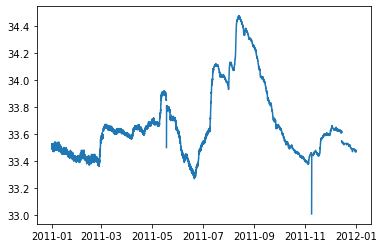

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2011-01-01') & (new_df.index < '2012-01-01')])

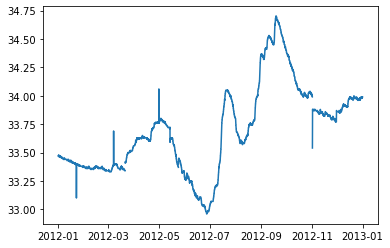

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2012-01-01') & (new_df.index < '2013-01-01')])

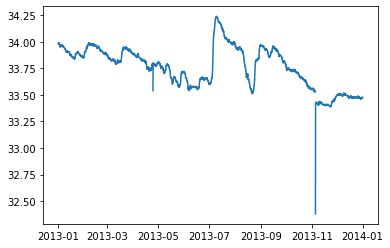

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2013-01-01') & (new_df.index < '2014-01-01')])

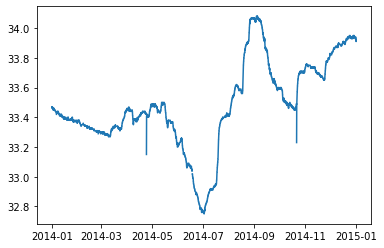

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2014-01-01') & (new_df.index < '2015-01-01')])

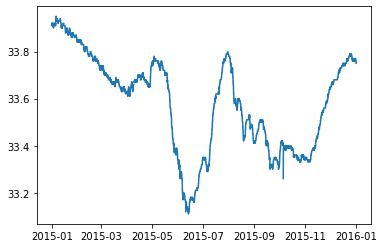

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2015-01-01') & (new_df.index < '2016-01-01')])

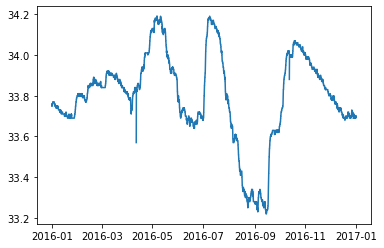

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2016-01-01') & (new_df.index < '2017-01-01')])

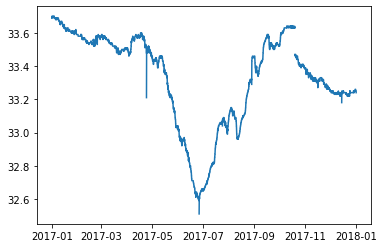

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2017-01-01') & (new_df.index < '2018-01-01')])

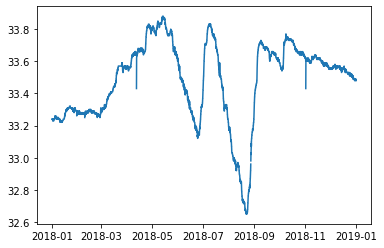

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2018-01-01') & (new_df.index < '2019-01-01')])

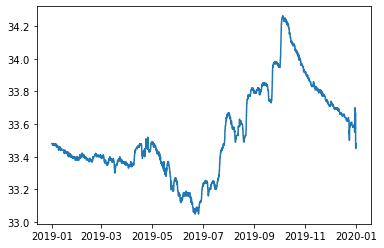

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2019-01-01') & (new_df.index < '2020-01-01')])

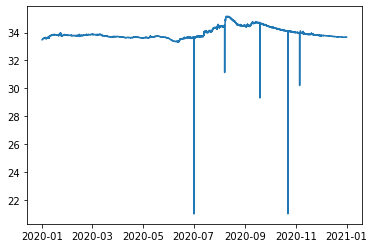

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2020-01-01') & (new_df.index < '2021-01-01')])

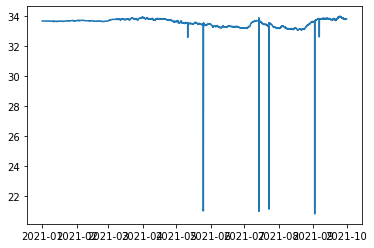

In [ ]:
plt.plot(new_df.el[(new_df.index >= '2021-01-01') & (new_df.index < '2022-01-01')])

In [ ]:
# 이동평균법을 이용한 데이터 정제
for n, term in new_df.groupby(by=[new_df.index.year, new_df.index.month, new_df.index.day]):
    for i in term[(term.el.values <= term.el.mean()*0.99) | (term.el.values < 20.0)].index:
        new_df.loc[i, 'el'] = np.nan

<AxesSubplot:>

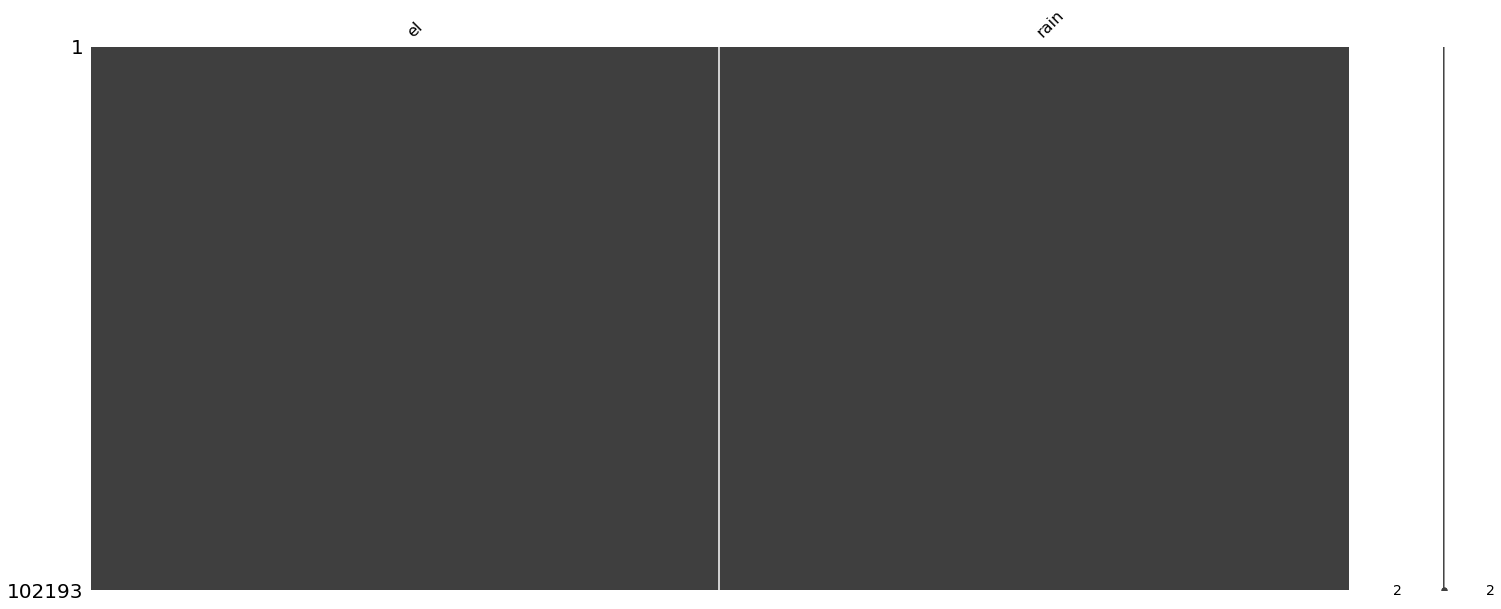

In [ ]:
new_df = new_df.interpolate(method='linear')
msno.matrix(new_df)

In [ ]:
new_df.describe()

,el,rain
count,102193.000000,102193.000000
mean,33.644584,0.157279
std,0.330883,1.254544
min,32.510000,0.000000
25%,33.420000,0.000000
50%,33.642000,0.000000
75%,33.820000,0.000000
max,35.170000,58.000000


In [ ]:
# 정제 데이터 저장
new_df.to_csv('engineered_gj.csv', index=True, encoding='euc-kr')

In [ ]:
# convert series to supervised learning lstm 사용 위해 시계열 시퀀스 데이터로 변환
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    temp = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1) 시퀀스 데이터 추가하기
    for i in range(n_in, 0, -1):
        cols.append(temp.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n) 시퀀스 예측 데이터 추가하기
    for i in range(0, n_out):
        cols.append(temp.shift(-i)) # 변환, 컬럼 추가
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)] # names에 예측 데이터 i = 0인 경우
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] # names에 예측 데이터

    # put it all together
    agg = concat(cols, axis=1) # 데이터 합치기
    agg.columns = names

    # drop rows with NaN values null값이 있는 행 지우기
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def model_compile(train_X):
    # design network 모델 파라미터 설정
    model = Sequential() # 시퀀스 데이터 사용할 모델
    model.add(LSTM(60, activation = 'tanh', input_shape=(train_X.shape[1], train_X.shape[2]))) # lstm모델 설정(층 : 60, 활성함수 : 'tanh', 입력 데이터 형태(input_shape)
    model.add(Dropout(0.5)) # 과적합 방지를 위한 피쳐 드롭아웃 설정(모델의 50%)
    model.add(Dense(1, activation = 'linear')) # dense 설정(활성함수 = 'linear')
    model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae']) # 모델 컴파일(오차함수 : loss, 옵티마이저 = 'adam', 정확도)
    model.summary()
    print('loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: ')
    return model

In [ ]:
# 결과값 평가를 위해 
def result_sum(xhat, yhat, train_X, train_y, test_X, test_y):
    # invert scaling for forecast 스케일링 값을 원래 값으로 복구
    inv_xhat = np.concatenate((train_X, xhat), axis=1) # 데이터 합치기
    inv_xhat = scaler.inverse_transform(inv_xhat) # 복구
    inv_xhat = inv_xhat[:,-1]

    inv_yhat = np.concatenate((test_X, yhat), axis=1) # 데이터 합치기
    inv_yhat = scaler.inverse_transform(inv_yhat) # 복구
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1)) # 원래의 데이터 형태로 복구
    inv_x = np.concatenate((train_X, train_y), axis=1)
    inv_x = scaler.inverse_transform(inv_x)
    inv_x = inv_x[:, -1]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, -1]

    # calculate RMSE
    trainRMSE = sqrt(mean_squared_error(inv_x, inv_xhat))
    trainR2 = r2_score(inv_x, inv_xhat)
    print('Train RMSE: %.3f' % trainRMSE)
    print('Train R2: %.3f' % trainR2)
    testRMSE = sqrt(mean_squared_error(inv_y, inv_yhat))
    testR2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % testRMSE)
    print('Test R2: %.3f' % testR2)

    
    # plot baseline and prediction 실제, 예측, 검증 데이터 관련 그래프
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.plot(inv_y, label='actual')
    plt.plot(inv_yhat, label='test')
    plt.xlabel('DATE')
    plt.ylabel('PRED')
    plt.legend()
    plt.show()
    
    return testR2

In [ ]:
def model_fitting(train_X, train_y, test_X, test_y, model):
    # early_stopping
#     early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

    # fit network
    # 모델 적용(학습 횟수(epoch) : 200, 한 번에 학습하는 데이터 개수(batch_size) : 15, 검증 데이터 설정, verbose : 2, shuffle 안함)
    history = model.fit(train_X, train_y, epochs=200, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False) # , callbacks=[early_stop])
    
    # plot history 플롯 설정(훈련, 검증 셋)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    plt.legend()
    plt.show()

    # make a prediction 예측하기
    xhat = model.predict(train_X)
    yhat = model.predict(test_X) # 검증 데이터X 예측

    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    return result_sum(xhat, yhat, train_X, train_y, test_X, test_y), model

In [ ]:
def split_data(values):
    trainSize = int(len(values)* 0.7)
    testSize = int(len(values)* 0.9)
    train = values[:trainSize, :]
    test = values[trainSize:testSize, :]
    act = values[testSize:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1] # 학습에 사용되는 데이터1, 2 (train[:, -1]가 도출될 수 있도록 하는 데이터와 train[:, -1] 데이터)
    test_X, test_y = test[:, :-1], test[:, -1] # 검증 데이터 (위와 같음)
    act_X, act_y = act[:, :-1], act[:, -1]

    # reshape input to be 3D [samples, timesteps, features] 3차원 데이터로 변환
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    act_X = act_X.reshape((act_X.shape[0], 1, act_X.shape[1]))
    
    print('train_X :', train_X.shape,
          '\ntrain_y :', train_y.shape,
          '\ntest_X :', test_X.shape,
          '\ntest_y :', test_y.shape,
          '\nact_X :', act_X.shape,
          '\nact_y :', act_y.shape)    
   
    return train_X, train_y, test_X, test_y, act_X, act_y

In [ ]:
def shift_data(values):
    reframed = series_to_supervised(values, 1, 1) # series_to_supervised 이용, 프레임 변환
    
    # drop columns we don't want to predict 예측하지 않는 컬럼 삭제
    reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
    
    # normalize features 피쳐 normalize
    global scaler
    scaler = MinMaxScaler(feature_range=(0, 1)) # 최대최소 스케일링(0, 1)
    scaled = scaler.fit_transform(reframed) # 지하수 데이터에 스케일러 적용

    # split into train and test sets
    return split_data(scaled)

In [ ]:
def show_rst(act_X, act_y, zhat):
    act_X = act_X.reshape((act_X.shape[0], act_X.shape[2]))
    act_y = act_y.reshape((act_y.shape[0], 1))
    kok = np.concatenate((act_X[:, ], zhat), axis=1)
    koko = np.concatenate((act_X, act_y), axis=1)
    print(koko.shape, kok.shape)
    koko = scaler.inverse_transform(koko)
    kok = scaler.inverse_transform(kok)
    
    plt.plot(koko[:, -1], label='actual')
    plt.plot(kok[:, -1], label='pred')
    plt.xlabel('DATE')
    plt.ylabel('PRED')
    plt.legend()
    plt.show()
    
    return pd.DataFrame(np.concatenate((koko[:,[ -1]], kok[:, [-1]]), axis=1), columns=['org', 'prd'])

train_X : (71534, 1, 2) 
train_y : (71534,) 
test_X : (20438, 1, 2) 
test_y : (20438,) 
act_X : (10220, 1, 2) 
act_y : (10220,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
1번 째 시도
Epoch 1/200
2385/2385 - 10s - loss: 0.0052 - acc: 1.3979e-05 - mae: 0.0511 - val_loss: 0.0048 - val_acc: 0.0000e+00 - val_mae: 0.0557
Epoch 2/200
2385/2385 - 6s - loss: 0.0021 - acc:

Epoch 54/200
2385/2385 - 9s - loss: 3.6222e-04 - acc: 1.3979e-05 - mae: 0.0132 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0265
Epoch 55/200
2385/2385 - 10s - loss: 3.4734e-04 - acc: 1.3979e-05 - mae: 0.0129 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0271
Epoch 56/200
2385/2385 - 9s - loss: 3.4848e-04 - acc: 1.3979e-05 - mae: 0.0130 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0271
Epoch 57/200
2385/2385 - 9s - loss: 3.4957e-04 - acc: 1.3979e-05 - mae: 0.0130 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0265
Epoch 58/200
2385/2385 - 9s - loss: 3.4712e-04 - acc: 1.3979e-05 - mae: 0.0130 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mae: 0.0271
Epoch 59/200
2385/2385 - 9s - loss: 3.4845e-04 - acc: 1.3979e-05 - mae: 0.0130 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0260
Epoch 60/200
2385/2385 - 9s - loss: 3.4849e-04 - acc: 1.3979e-05 - mae: 0.0130 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mae: 0.0252
Epoch 61/200
2385/2385 - 9s - los

2385/2385 - 7s - loss: 3.2627e-04 - acc: 1.3979e-05 - mae: 0.0123 - val_loss: 6.9141e-04 - val_acc: 0.0000e+00 - val_mae: 0.0190
Epoch 113/200
2385/2385 - 8s - loss: 3.3091e-04 - acc: 1.3979e-05 - mae: 0.0123 - val_loss: 6.4740e-04 - val_acc: 0.0000e+00 - val_mae: 0.0183
Epoch 114/200
2385/2385 - 8s - loss: 3.2523e-04 - acc: 1.3979e-05 - mae: 0.0123 - val_loss: 6.5361e-04 - val_acc: 0.0000e+00 - val_mae: 0.0185
Epoch 115/200
2385/2385 - 7s - loss: 3.3596e-04 - acc: 1.3979e-05 - mae: 0.0124 - val_loss: 6.7749e-04 - val_acc: 0.0000e+00 - val_mae: 0.0189
Epoch 116/200
2385/2385 - 7s - loss: 3.2881e-04 - acc: 1.3979e-05 - mae: 0.0123 - val_loss: 6.2069e-04 - val_acc: 0.0000e+00 - val_mae: 0.0179
Epoch 117/200
2385/2385 - 7s - loss: 3.2891e-04 - acc: 1.3979e-05 - mae: 0.0123 - val_loss: 6.2007e-04 - val_acc: 0.0000e+00 - val_mae: 0.0179
Epoch 118/200
2385/2385 - 7s - loss: 3.2594e-04 - acc: 1.3979e-05 - mae: 0.0123 - val_loss: 6.5932e-04 - val_acc: 0.0000e+00 - val_mae: 0.0186
Epoch 119/200

Epoch 170/200
2385/2385 - 6s - loss: 3.3184e-04 - acc: 1.3979e-05 - mae: 0.0120 - val_loss: 4.9427e-04 - val_acc: 0.0000e+00 - val_mae: 0.0150
Epoch 171/200
2385/2385 - 7s - loss: 3.3779e-04 - acc: 1.3979e-05 - mae: 0.0121 - val_loss: 4.8336e-04 - val_acc: 0.0000e+00 - val_mae: 0.0149
Epoch 172/200
2385/2385 - 6s - loss: 3.3174e-04 - acc: 1.3979e-05 - mae: 0.0120 - val_loss: 4.5152e-04 - val_acc: 0.0000e+00 - val_mae: 0.0141
Epoch 173/200
2385/2385 - 6s - loss: 3.4107e-04 - acc: 1.3979e-05 - mae: 0.0121 - val_loss: 4.6954e-04 - val_acc: 0.0000e+00 - val_mae: 0.0146
Epoch 174/200
2385/2385 - 7s - loss: 3.3929e-04 - acc: 1.3979e-05 - mae: 0.0121 - val_loss: 4.3481e-04 - val_acc: 0.0000e+00 - val_mae: 0.0138
Epoch 175/200
2385/2385 - 7s - loss: 3.3307e-04 - acc: 1.3979e-05 - mae: 0.0120 - val_loss: 4.5970e-04 - val_acc: 0.0000e+00 - val_mae: 0.0143
Epoch 176/200
2385/2385 - 6s - loss: 3.3370e-04 - acc: 1.3979e-05 - mae: 0.0120 - val_loss: 4.3922e-04 - val_acc: 0.0000e+00 - val_mae: 0.0138

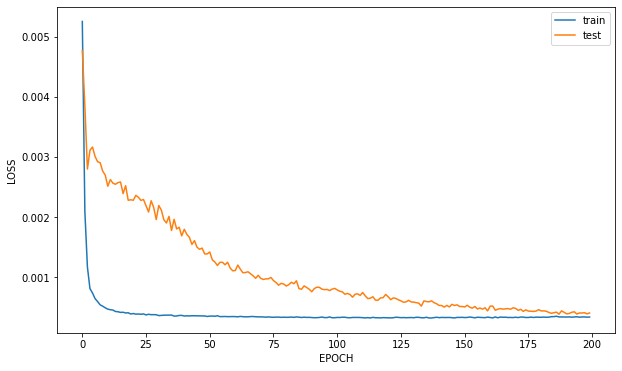

Train RMSE: 0.071
Train R2: 0.952
Test RMSE: 0.054
Test R2: 0.959


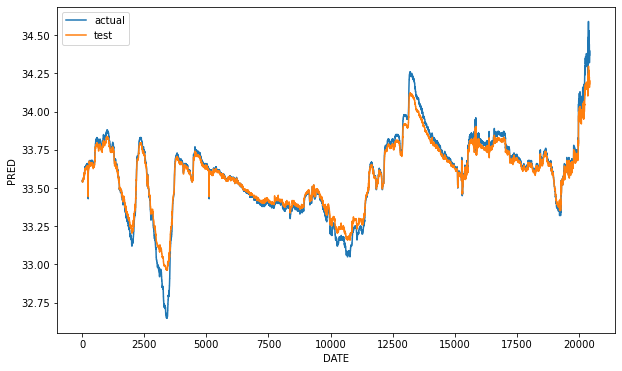

(10220, 3) (10220, 3)


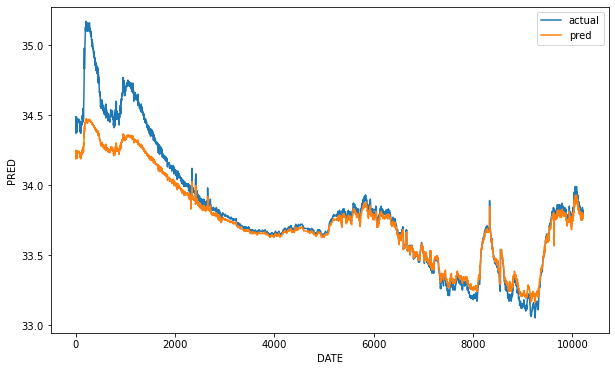

,org,prd
0,34.369999,34.187664
1,34.490002,34.187664
2,34.450001,34.251087
3,34.410000,34.230934
4,34.389999,34.209801
...,...,...
10215,33.820000,33.768440
10216,33.810001,33.785778
10217,33.820000,33.777122
10218,33.810001,33.785778


In [ ]:
# start(num) : 0-모델 재생성 1-모델 적용

# 모델 재생성
# ensure all data is float 데이터를 float32로 변환
values = new_df.values
values = values.astype('float32')

train_X, train_y, test_X, test_y, act_X, act_y = shift_data(values)
model = model_compile(train_X)

# r2, model = model_fitting(train_X, train_y, test_X, test_y, model)
# zhat = model.predict(act_X)

coin = 1
while True:
    print(f'{coin}번 째 시도')
    r2, model = model_fitting(train_X, train_y, test_X, test_y, model)
    if r2 < 0.9:
        coin += 1
        continue
    else:
        zhat = model.predict(act_X)
        break
        
show_rst(act_X, act_y, zhat)